In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**The Notebook contains the code for Building Neural Network with the MNIST data**

- **Target of Book**: As we have achieved a good accuracy of 99.4 consistently, and even though we had tried by adding few regularization techniques introducing normalization processes to the architecture, let us try to implement & introduce other normalization techniques LN (Layer Normalization), Group Normalization ( Group Normalization) and get the insights of usage and difference between the three.

* **Description**: 

1. The network architecture is built up on involving special features.

2. This network has been reduced to usage of lesser number of parameters (8,442) ~ 8 thousand parameter, which makes it a lighter model. 

3. The Architecture only has Convolutions, Relu activation function, Max Pooling, and returning result with softmax, which returns a list of probabilites of classes and will contain either of (BatchNormalization, Dropouts, Augmentations, GAP Layers).

4. The **Receptive Field looks out a 36x36** at the end.

5.  **EPOCHS**: Iterated the dataset for **20** times.
6. BATCHSIZE : 128 

7. Accuracies are mentioned in the "Results" section and "analysis" is made.

8. As per my view & visualizations, the model's accuracy has been great compared to previous architecture it starts with underfitted accuracies and regain the good accuracy score.


**A. Importing Libraries**

In [ ]:
from __future__ import print_function
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets,transforms

In [ ]:
from sample_data.model import Setup 

**B. Dataloader/ Loading the data**




In [ ]:
# Defining transformations such that our data can be transformed in such a way 

train_transforms = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081,))])
test_transforms = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

In [ ]:
train = datasets.MNIST("./data",train=True,download=True,transform=train_transforms)
test = datasets.MNIST("./data",train=False,download=True,transform=test_transforms)

**C. Setting Configurations for processors & dataloading**

In [ ]:
SEED = 1 
gpu = torch.cuda.is_available()
print("Is cuda available: ",gpu)
torch.manual_seed(SEED)

if gpu:
  torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if gpu else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

Is cuda available:  True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



**D. Visualization & understanding of Images**

torch.Size([128, 1, 28, 28]) torch.Size([128])


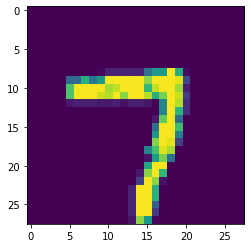

In [ ]:
images,labels = next(iter(train_loader))
print(images.shape,labels.shape)
plt.imshow(images[10].numpy().squeeze())

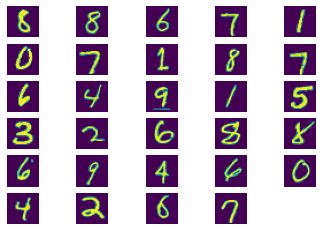

In [ ]:
figure = plt.figure() 
for idx in range(1,30):
  plt.subplot(6,5,idx)
  plt.axis('off')
  plt.imshow(images[idx].numpy().squeeze())

**E. Building Model Architecture**

In [ ]:
ts = torch.randn(1,28,28)
ts = ts.reshape(-1,8)
print(ts.shape)

torch.Size([98, 8])


**F.Understanding the summary of Architecture**

In [ ]:
# !pip install torchsummary
# from sample_data.model import Setup
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Setup("BN").to(device)
summary(model, input_size=(1,28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
            Conv2d-4           [-1, 10, 26, 26]             730
       BatchNorm2d-5           [-1, 10, 26, 26]              20
              ReLU-6           [-1, 10, 26, 26]               0
            Conv2d-7           [-1, 16, 24, 24]           1,456
       BatchNorm2d-8           [-1, 16, 24, 24]              32
              ReLU-9           [-1, 16, 24, 24]               0
        MaxPool2d-10           [-1, 16, 12, 12]               0
           Conv2d-11           [-1, 20, 10, 10]           2,900
      BatchNorm2d-12           [-1, 20, 10, 10]              40
             ReLU-13           [-1, 20, 10, 10]               0
          Dropout-14           [-1

**G. Defining & deriving the training & its results as well as test/validation results**

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  
  for batch_idx, (data, target) in enumerate(pbar):

    data, target = data.to(device), target.to(device)
  
    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} train-Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    # return train_acc,train_losses

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, val-Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    # return test_acc,test_losses

In [ ]:
from sample_data.model import Setup

**Layer Normalization**

In [ ]:
lst2 = []
model =  Setup("LN").to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
print(len(train_loader))
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

469
EPOCH: 0


Loss=0.09822594374418259 Batch_id=468 train-Accuracy=91.22: 100%|██████████| 469/469 [00:16<00:00, 27.69it/s]



Test set: Average loss: 0.0896, val-Accuracy: 9731/10000 (97.31%)

EPOCH: 1


Loss=0.0875488743185997 Batch_id=468 train-Accuracy=97.41: 100%|██████████| 469/469 [00:18<00:00, 25.00it/s]



Test set: Average loss: 0.0560, val-Accuracy: 9824/10000 (98.24%)

EPOCH: 2


Loss=0.02572440356016159 Batch_id=468 train-Accuracy=97.94: 100%|██████████| 469/469 [00:17<00:00, 27.53it/s]



Test set: Average loss: 0.0463, val-Accuracy: 9857/10000 (98.57%)

EPOCH: 3


Loss=0.05665427818894386 Batch_id=468 train-Accuracy=98.30: 100%|██████████| 469/469 [00:14<00:00, 33.16it/s]



Test set: Average loss: 0.0386, val-Accuracy: 9881/10000 (98.81%)

EPOCH: 4


Loss=0.009627554565668106 Batch_id=468 train-Accuracy=98.43: 100%|██████████| 469/469 [00:15<00:00, 30.22it/s]



Test set: Average loss: 0.0392, val-Accuracy: 9872/10000 (98.72%)

EPOCH: 5


Loss=0.06131136789917946 Batch_id=468 train-Accuracy=98.62: 100%|██████████| 469/469 [00:14<00:00, 31.72it/s]



Test set: Average loss: 0.0358, val-Accuracy: 9886/10000 (98.86%)

EPOCH: 6


Loss=0.04101940244436264 Batch_id=468 train-Accuracy=98.69: 100%|██████████| 469/469 [00:17<00:00, 26.72it/s]



Test set: Average loss: 0.0355, val-Accuracy: 9893/10000 (98.93%)

EPOCH: 7


Loss=0.051611438393592834 Batch_id=468 train-Accuracy=98.81: 100%|██████████| 469/469 [00:16<00:00, 29.14it/s]



Test set: Average loss: 0.0306, val-Accuracy: 9910/10000 (99.10%)

EPOCH: 8


Loss=0.062473129481077194 Batch_id=468 train-Accuracy=98.89: 100%|██████████| 469/469 [00:14<00:00, 31.74it/s]



Test set: Average loss: 0.0304, val-Accuracy: 9911/10000 (99.11%)

EPOCH: 9


Loss=0.02666345424950123 Batch_id=468 train-Accuracy=98.95: 100%|██████████| 469/469 [00:14<00:00, 32.30it/s]



Test set: Average loss: 0.0302, val-Accuracy: 9912/10000 (99.12%)

EPOCH: 10


Loss=0.02186974324285984 Batch_id=468 train-Accuracy=99.02: 100%|██████████| 469/469 [00:16<00:00, 29.17it/s]



Test set: Average loss: 0.0270, val-Accuracy: 9921/10000 (99.21%)

EPOCH: 11


Loss=0.005202614236623049 Batch_id=468 train-Accuracy=99.06: 100%|██████████| 469/469 [00:18<00:00, 24.97it/s]



Test set: Average loss: 0.0291, val-Accuracy: 9908/10000 (99.08%)

EPOCH: 12


Loss=0.00377675355412066 Batch_id=468 train-Accuracy=99.05: 100%|██████████| 469/469 [00:17<00:00, 26.98it/s]



Test set: Average loss: 0.0338, val-Accuracy: 9895/10000 (98.95%)

EPOCH: 13


Loss=0.010127878747880459 Batch_id=468 train-Accuracy=99.12: 100%|██████████| 469/469 [00:15<00:00, 29.85it/s]



Test set: Average loss: 0.0290, val-Accuracy: 9909/10000 (99.09%)

EPOCH: 14


Loss=0.009456329047679901 Batch_id=468 train-Accuracy=99.14: 100%|██████████| 469/469 [00:17<00:00, 26.81it/s]



Test set: Average loss: 0.0300, val-Accuracy: 9908/10000 (99.08%)

EPOCH: 15


Loss=0.04111354798078537 Batch_id=468 train-Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 30.79it/s]



Test set: Average loss: 0.0334, val-Accuracy: 9899/10000 (98.99%)

EPOCH: 16


Loss=0.01878650300204754 Batch_id=468 train-Accuracy=99.26: 100%|██████████| 469/469 [00:15<00:00, 30.90it/s]



Test set: Average loss: 0.0256, val-Accuracy: 9919/10000 (99.19%)

EPOCH: 17


Loss=0.020326392725110054 Batch_id=468 train-Accuracy=99.27: 100%|██████████| 469/469 [00:15<00:00, 30.66it/s]



Test set: Average loss: 0.0261, val-Accuracy: 9915/10000 (99.15%)

EPOCH: 18


Loss=0.012539873830974102 Batch_id=468 train-Accuracy=99.26: 100%|██████████| 469/469 [00:16<00:00, 29.09it/s]



Test set: Average loss: 0.0277, val-Accuracy: 9921/10000 (99.21%)

EPOCH: 19


Loss=0.0027256060857325792 Batch_id=468 train-Accuracy=99.29: 100%|██████████| 469/469 [00:14<00:00, 32.07it/s]



Test set: Average loss: 0.0258, val-Accuracy: 9913/10000 (99.13%)



In [ ]:

from tqdm import tqdm

train1_losses = []
test1_losses = []
train1_acc = []
test1_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  
  for batch_idx, (data, target) in enumerate(pbar):

    data, target = data.to(device), target.to(device)
  
    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train1_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} train-Accuracy={100*correct/processed:0.2f}')
    train1_acc.append(100*correct/processed)
    # return train_acc,train_losses

def test(model, device, test_loader):
    model.eval()
    test1_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test1_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test1_loss /= len(test_loader.dataset)
    test1_losses.append(test1_loss)

    print('\nTest set: Average loss: {:.4f}, val-Accuracy: {}/{} ({:.2f}%)\n'.format(
        test1_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test1_acc.append(100. * correct / len(test_loader.dataset))
    # return test_acc,test_losses

lst2 = []
model =  Setup("GN").to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
print(len(train_loader))
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

469
EPOCH: 0


Loss=0.07039842754602432 Batch_id=468 train-Accuracy=90.65: 100%|██████████| 469/469 [00:14<00:00, 31.63it/s]



Test set: Average loss: 0.0839, val-Accuracy: 9754/10000 (97.54%)

EPOCH: 1


Loss=0.051118601113557816 Batch_id=468 train-Accuracy=97.48: 100%|██████████| 469/469 [00:14<00:00, 31.71it/s]



Test set: Average loss: 0.0521, val-Accuracy: 9833/10000 (98.33%)

EPOCH: 2


Loss=0.04211515188217163 Batch_id=468 train-Accuracy=98.20: 100%|██████████| 469/469 [00:16<00:00, 29.19it/s]



Test set: Average loss: 0.0601, val-Accuracy: 9805/10000 (98.05%)

EPOCH: 3


Loss=0.08669980615377426 Batch_id=468 train-Accuracy=98.39: 100%|██████████| 469/469 [00:19<00:00, 23.94it/s]



Test set: Average loss: 0.0435, val-Accuracy: 9869/10000 (98.69%)

EPOCH: 4


Loss=0.05475062504410744 Batch_id=468 train-Accuracy=98.62: 100%|██████████| 469/469 [00:19<00:00, 24.39it/s]



Test set: Average loss: 0.0398, val-Accuracy: 9872/10000 (98.72%)

EPOCH: 5


Loss=0.02523859404027462 Batch_id=468 train-Accuracy=98.72: 100%|██████████| 469/469 [00:17<00:00, 27.25it/s]



Test set: Average loss: 0.0398, val-Accuracy: 9875/10000 (98.75%)

EPOCH: 6


Loss=0.027034083381295204 Batch_id=468 train-Accuracy=98.82: 100%|██████████| 469/469 [00:17<00:00, 27.56it/s]



Test set: Average loss: 0.0380, val-Accuracy: 9883/10000 (98.83%)

EPOCH: 7


Loss=0.057978566735982895 Batch_id=468 train-Accuracy=98.89: 100%|██████████| 469/469 [00:16<00:00, 28.32it/s]



Test set: Average loss: 0.0318, val-Accuracy: 9904/10000 (99.04%)

EPOCH: 8


Loss=0.05781368538737297 Batch_id=468 train-Accuracy=98.95: 100%|██████████| 469/469 [00:16<00:00, 28.29it/s]



Test set: Average loss: 0.0306, val-Accuracy: 9904/10000 (99.04%)

EPOCH: 9


Loss=0.03729275241494179 Batch_id=468 train-Accuracy=99.05: 100%|██████████| 469/469 [00:14<00:00, 31.97it/s]



Test set: Average loss: 0.0308, val-Accuracy: 9896/10000 (98.96%)

EPOCH: 10


Loss=0.09872130304574966 Batch_id=468 train-Accuracy=99.03: 100%|██████████| 469/469 [00:15<00:00, 30.74it/s]



Test set: Average loss: 0.0330, val-Accuracy: 9891/10000 (98.91%)

EPOCH: 11


Loss=0.030459381639957428 Batch_id=468 train-Accuracy=99.11: 100%|██████████| 469/469 [00:14<00:00, 31.95it/s]



Test set: Average loss: 0.0308, val-Accuracy: 9898/10000 (98.98%)

EPOCH: 12


Loss=0.006369519513100386 Batch_id=468 train-Accuracy=99.10: 100%|██████████| 469/469 [00:14<00:00, 31.40it/s]



Test set: Average loss: 0.0286, val-Accuracy: 9913/10000 (99.13%)

EPOCH: 13


Loss=0.02930898219347 Batch_id=468 train-Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 31.17it/s]



Test set: Average loss: 0.0327, val-Accuracy: 9892/10000 (98.92%)

EPOCH: 14


Loss=0.02376864105463028 Batch_id=468 train-Accuracy=99.26: 100%|██████████| 469/469 [00:14<00:00, 31.96it/s]



Test set: Average loss: 0.0283, val-Accuracy: 9916/10000 (99.16%)

EPOCH: 15


Loss=0.0067425980232656 Batch_id=468 train-Accuracy=99.30: 100%|██████████| 469/469 [00:14<00:00, 31.74it/s]



Test set: Average loss: 0.0285, val-Accuracy: 9910/10000 (99.10%)

EPOCH: 16


Loss=0.012703611515462399 Batch_id=468 train-Accuracy=99.30: 100%|██████████| 469/469 [00:15<00:00, 30.93it/s]



Test set: Average loss: 0.0251, val-Accuracy: 9923/10000 (99.23%)

EPOCH: 17


Loss=0.005132834427058697 Batch_id=468 train-Accuracy=99.36: 100%|██████████| 469/469 [00:15<00:00, 30.49it/s]



Test set: Average loss: 0.0252, val-Accuracy: 9928/10000 (99.28%)

EPOCH: 18


Loss=0.001174401375465095 Batch_id=468 train-Accuracy=99.36: 100%|██████████| 469/469 [00:15<00:00, 31.03it/s]



Test set: Average loss: 0.0302, val-Accuracy: 9901/10000 (99.01%)

EPOCH: 19


Loss=0.002263591857627034 Batch_id=468 train-Accuracy=99.36: 100%|██████████| 469/469 [00:15<00:00, 30.78it/s]



Test set: Average loss: 0.0276, val-Accuracy: 9915/10000 (99.15%)



In [ ]:


train2_losses = []
test2_losses = []
train2_acc = []
test2_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  
  for batch_idx, (data, target) in enumerate(pbar):

    data, target = data.to(device), target.to(device)
  
    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    l1_lambda = 0.001
    l1_norm = sum(p.abs().sum() for p in model.parameters())
 
    loss = loss + l1_lambda * l1_norm
    train2_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} train-Accuracy={100*correct/processed:0.2f}')
    train2_acc.append(100*correct/processed)
    # return train_acc,train_losses

def test(model, device, test_loader):
    model.eval()
    test2_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test2_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test2_loss /= len(test_loader.dataset)
    test2_losses.append(test2_loss)

    print('\nTest set: Average loss: {:.4f}, val-Accuracy: {}/{} ({:.2f}%)\n'.format(
        test2_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test2_acc.append(100. * correct / len(test_loader.dataset))
    # return test_acc,test_losses

lst2 = []
model =  Setup("BN").to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
print(len(train_loader))
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

469
EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=0.42674723267555237 Batch_id=468 train-Accuracy=94.21: 100%|██████████| 469/469 [00:16<00:00, 28.75it/s]



Test set: Average loss: 0.1126, val-Accuracy: 9737/10000 (97.37%)

EPOCH: 1


Loss=0.30009257793426514 Batch_id=468 train-Accuracy=97.88: 100%|██████████| 469/469 [00:15<00:00, 29.44it/s]



Test set: Average loss: 0.0651, val-Accuracy: 9822/10000 (98.22%)

EPOCH: 2


Loss=0.3489333987236023 Batch_id=468 train-Accuracy=97.96: 100%|██████████| 469/469 [00:15<00:00, 29.84it/s]



Test set: Average loss: 0.1038, val-Accuracy: 9702/10000 (97.02%)

EPOCH: 3


Loss=0.2757153809070587 Batch_id=468 train-Accuracy=97.99: 100%|██████████| 469/469 [00:16<00:00, 28.59it/s]



Test set: Average loss: 0.0717, val-Accuracy: 9817/10000 (98.17%)

EPOCH: 4


Loss=0.24745072424411774 Batch_id=468 train-Accuracy=98.03: 100%|██████████| 469/469 [00:16<00:00, 29.15it/s]



Test set: Average loss: 0.0898, val-Accuracy: 9729/10000 (97.29%)

EPOCH: 5


Loss=0.2999730706214905 Batch_id=468 train-Accuracy=98.22: 100%|██████████| 469/469 [00:16<00:00, 28.39it/s]



Test set: Average loss: 0.0675, val-Accuracy: 9810/10000 (98.10%)

EPOCH: 6


Loss=0.23564352095127106 Batch_id=468 train-Accuracy=98.14: 100%|██████████| 469/469 [00:16<00:00, 27.73it/s]



Test set: Average loss: 0.0548, val-Accuracy: 9859/10000 (98.59%)

EPOCH: 7


Loss=0.24792681634426117 Batch_id=468 train-Accuracy=98.14: 100%|██████████| 469/469 [00:16<00:00, 29.26it/s]



Test set: Average loss: 0.0767, val-Accuracy: 9780/10000 (97.80%)

EPOCH: 8


Loss=0.22399574518203735 Batch_id=468 train-Accuracy=98.14: 100%|██████████| 469/469 [00:16<00:00, 28.96it/s]



Test set: Average loss: 0.0851, val-Accuracy: 9758/10000 (97.58%)

EPOCH: 9


Loss=0.2644430100917816 Batch_id=468 train-Accuracy=98.18: 100%|██████████| 469/469 [00:16<00:00, 28.98it/s]



Test set: Average loss: 0.0953, val-Accuracy: 9740/10000 (97.40%)

EPOCH: 10


Loss=0.27245962619781494 Batch_id=468 train-Accuracy=98.20: 100%|██████████| 469/469 [00:16<00:00, 29.03it/s]



Test set: Average loss: 0.0650, val-Accuracy: 9829/10000 (98.29%)

EPOCH: 11


Loss=0.2523805797100067 Batch_id=468 train-Accuracy=98.17: 100%|██████████| 469/469 [00:17<00:00, 26.58it/s]



Test set: Average loss: 0.0700, val-Accuracy: 9826/10000 (98.26%)

EPOCH: 12


Loss=0.20465929806232452 Batch_id=468 train-Accuracy=98.24: 100%|██████████| 469/469 [00:16<00:00, 29.14it/s]



Test set: Average loss: 0.0687, val-Accuracy: 9770/10000 (97.70%)

EPOCH: 13


Loss=0.1886860430240631 Batch_id=468 train-Accuracy=98.30: 100%|██████████| 469/469 [00:16<00:00, 28.76it/s]



Test set: Average loss: 0.0665, val-Accuracy: 9808/10000 (98.08%)

EPOCH: 14


Loss=0.19906318187713623 Batch_id=468 train-Accuracy=98.28: 100%|██████████| 469/469 [00:16<00:00, 28.51it/s]



Test set: Average loss: 0.0723, val-Accuracy: 9790/10000 (97.90%)

EPOCH: 15


Loss=0.19008569419384003 Batch_id=468 train-Accuracy=98.22: 100%|██████████| 469/469 [00:16<00:00, 28.37it/s]



Test set: Average loss: 0.0490, val-Accuracy: 9861/10000 (98.61%)

EPOCH: 16


Loss=0.203877791762352 Batch_id=468 train-Accuracy=98.31: 100%|██████████| 469/469 [00:16<00:00, 28.24it/s]



Test set: Average loss: 0.0719, val-Accuracy: 9791/10000 (97.91%)

EPOCH: 17


Loss=0.17973382771015167 Batch_id=468 train-Accuracy=98.30: 100%|██████████| 469/469 [00:16<00:00, 28.15it/s]



Test set: Average loss: 0.0650, val-Accuracy: 9822/10000 (98.22%)

EPOCH: 18


Loss=0.23444411158561707 Batch_id=468 train-Accuracy=98.21: 100%|██████████| 469/469 [00:16<00:00, 28.80it/s]



Test set: Average loss: 0.0532, val-Accuracy: 9850/10000 (98.50%)

EPOCH: 19


Loss=0.1875326782464981 Batch_id=468 train-Accuracy=98.27: 100%|██████████| 469/469 [00:16<00:00, 28.97it/s]



Test set: Average loss: 0.0835, val-Accuracy: 9764/10000 (97.64%)



Text(0.5, 1.0, 'Test Accuracy')

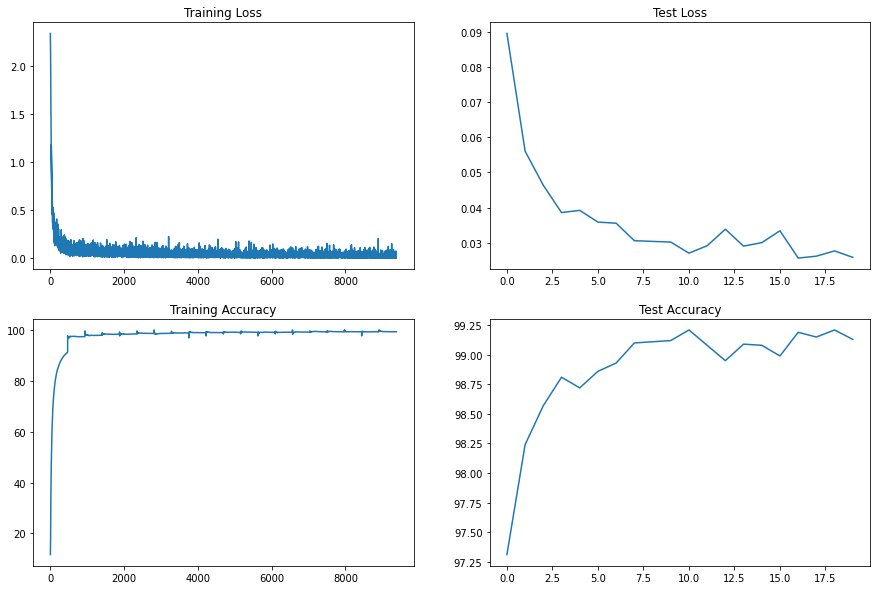

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot([t.cpu().item() for t in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Text(0.5, 1.0, 'Test Accuracy')

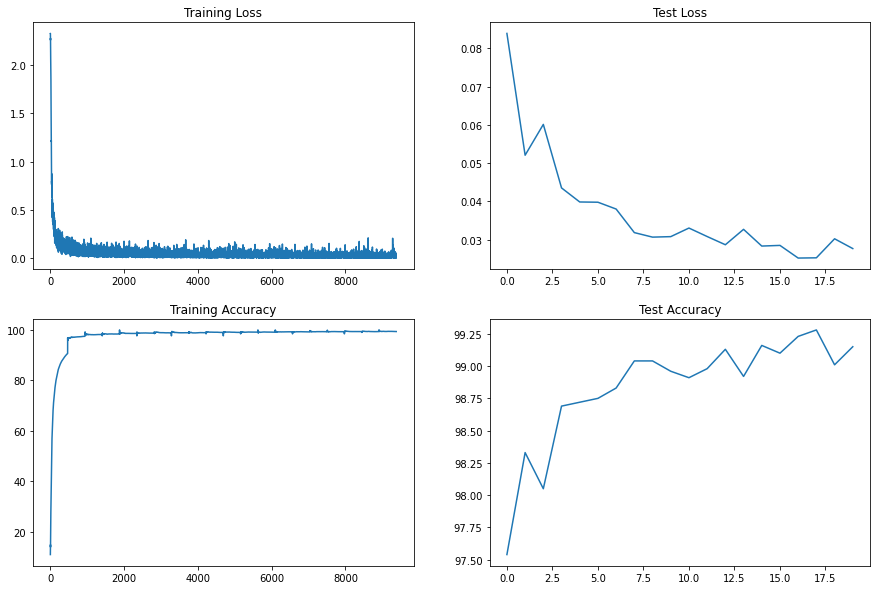

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot([t.cpu().item() for t in train1_losses])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train1_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test1_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test1_acc)
axs[1, 1].set_title("Test Accuracy")

Text(0.5, 1.0, 'Test Accuracy')

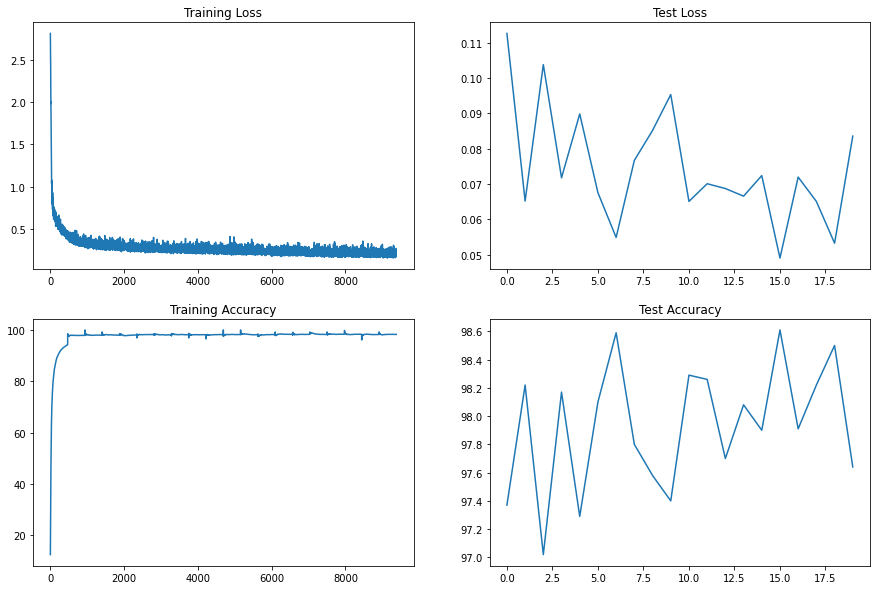

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot([t.cpu().item() for t in train2_losses])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train2_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test2_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test2_acc)
axs[1, 1].set_title("Test Accuracy")

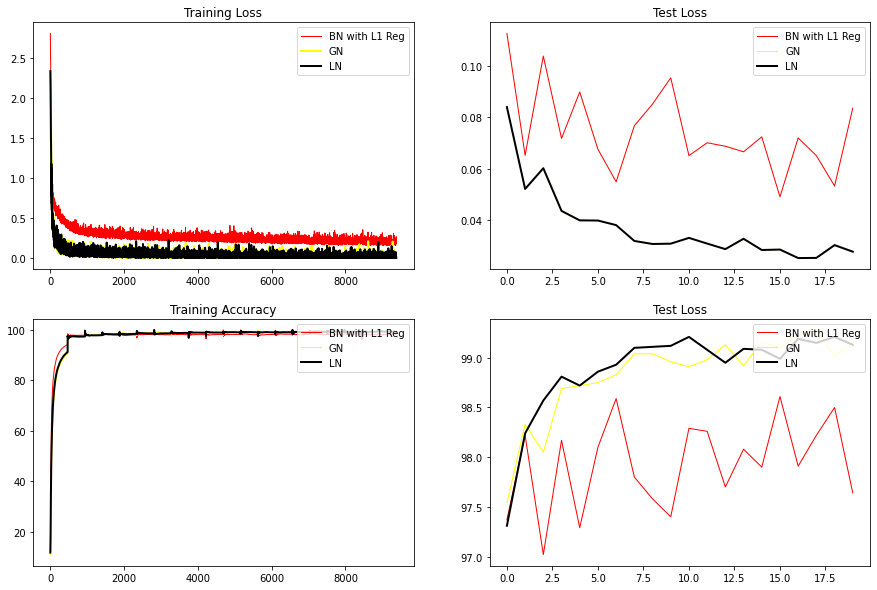

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0,0].set_title("Training Loss")
axs[0, 0].plot([t.cpu().item() for t in train2_losses],color='red',linewidth='1',label='BN with L1 Reg')
axs[0,0].plot([t.cpu().item() for t in train1_losses],color='Yellow',label='GN',linewidth='2')
axs[0, 0].plot([t.cpu().item() for t in train_losses],color='black',label="LN",linewidth='2')
axs[0,0].legend(loc='upper right')

axs[1,0].set_title("Training Accuracy")
axs[1, 0].plot(train2_acc,color='red',linewidth='1',label='BN with L1 Reg')
axs[1,0].plot(train1_acc,color='Yellow',linewidth='1',label='GN')
axs[1,0].plot(train_acc,color='black',linewidth='2',label='LN')
axs[1,0].legend(loc='upper right')

axs[0,1].set_title("Test Loss")
axs[0, 1].plot(test2_losses,color='red',linewidth='1',label='BN with L1 Reg')
axs[0,1].plot(test1_losses,color='Yellow',linewidth='1',label='GN')
axs[0,1].plot(test1_losses,color='black',linewidth='2',label='LN')
axs[0,1].legend(loc='upper right')

axs[1,1].set_title("Test Loss")
axs[1, 1].plot(test2_acc,color='red',linewidth='1',label='BN with L1 Reg')
axs[1,1].plot(test1_acc,color='Yellow',linewidth='1',label='GN')
axs[1,1].plot(test_acc,color='black',linewidth='2',label='LN')
axs[1,1].legend(loc='upper right')

# 2. Results:

**Note: The best & highest accuracies aren't written here, but the ones with less provoke to overfitting.**

**GN has achieved good result**

Top Accuracies: 

**BN with L1 Reg : 98.31 & 97.7**

**GN :  99.36 & 99.28**

**LN: 99.29 & 99.21**
  

# 3. Analysis:

1. Here, LN & GN has performed a quite good, whereas BN + L1 Reg dipped in the performance as compared to them. GN can be considered as a competitive to BN. 